# Title: Windows Host Explorer
**Notebook Version:** 1.0<br>
**Python Version:** Python 3.6 (including Python 3.6 - AzureML)<br>
**Required Packages**: kqlmagic, msticpy, pandas, numpy, matplotlib, networkx, ipywidgets, ipython, scikit_learn, dnspython, ipwhois, folium, maxminddb_geolite2, holoviews<br>
**Platforms Supported**:
- Azure Notebooks Free Compute
- Azure Notebooks DSVM
- OS Independent

**Data Sources Required**:
- Log Analytics - SecurityAlert, SecurityEvent (EventIDs 4688 and 4624/25), AzureNetworkAnalytics_CL, Heartbeat
- (Optional) - VirusTotal (with API key)

## Description:
Brings together a series of queries and visualizations to help you determine the security state of the Windows host or virtual machine that you are investigating.


<a id='toc'></a>
# Table of Contents
- [Setup and Authenticate](#setup)

- [Get Host Name](#get_hostname)
- [Related Alerts](#related_alerts)
- [Host Logons](#host_logons)
  - [Failed Logons](#failed_logons)
  - [Session Processes](#examine_win_logon_sess)
- [Check for IOCs in Commandline](#cmdlineiocs)
  - [VirusTotal lookup](#virustotallookup)
- [Network Data](#comms_to_other_hosts)
- [Appendices](#appendices)
  - [Saving data to Excel](#appendices)


<a id='setup'></a>[Contents](#toc)
# Setup

Make sure that you have installed packages specified in the setup (uncomment the lines to execute)

## Install Packages
The first time this cell runs for a new Azure Notebooks project or local Python environment it will take several minutes to download and install the packages. In subsequent runs it should run quickly and confirm that package dependencies are already installed. Unless you want to upgrade the packages you can feel free to skip execution of the next cell.

If you see any import failures (```ImportError```) in the notebook, please re-run this cell and answer 'y', then re-run the cell where the failure occurred.

Note you may see some warnings about package incompatibility with certain packages. This does not affect the functionality of this notebook but you may need to upgrade the packages producing the warnings to a more recent version.

In [ ]:
import sys
import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)

MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

# Package Installs - try to avoid if they are already installed
try:
    import msticpy.sectools as sectools
    import Kqlmagic
    from dns import reversename, resolver
    from ipwhois import IPWhois
    import folium
    
    print('If you answer "n" this cell will exit with an error in order to avoid the pip install calls,')
    print('This error can safely be ignored.')
    resp = input('msticpy and Kqlmagic packages are already loaded. Do you want to re-install? (y/n)')
    if resp.strip().lower() != 'y':
        sys.exit('pip install aborted - you may skip this error and continue.')
    else:
        print('After installation has completed, restart the current kernel and run '
              'the notebook again skipping this cell.')
except ImportError:
    pass

print('\nPlease wait. Installing required packages. This may take a few minutes...')
!pip install git+https://github.com/microsoft/msticpy --upgrade --user
!pip install Kqlmagic --no-cache-dir --upgrade --user
!pip install holoviews
!pip install dnspython --upgrade 
!pip install ipwhois --upgrade 
!pip install folium --upgrade

# Uncomment to refresh the maxminddb database
# !pip install maxminddb-geolite2 --upgrade 
print('To ensure that the latest versions of the installed libraries '
      'are used, please restart the current kernel and run '
      'the notebook again skipping this cell.')

In [1]:
# Imports
import sys
import warnings

MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

import numpy as np
from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

import msticpy.sectools as sectools
import msticpy.nbtools as mas
import msticpy.nbtools.kql as qry
import msticpy.nbtools.nbdisplay as nbdisp

WIDGET_DEFAULTS = {'layout': widgets.Layout(width='95%'),
                   'style': {'description_width': 'initial'}}

# Some of our dependencies (networkx) still use deprecated Matplotlib
# APIs - we can't do anything about it so suppress them from view
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

display(HTML(mas.util._TOGGLE_CODE_PREPARE_STR))
HTML('''
    <script type="text/javascript">
        IPython.notebook.kernel.execute("nb_query_string='".concat(window.location.search).concat("'"));
    </script>
    ''');

### Get WorkspaceId
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.

In [2]:
import os
from msticpy.nbtools.wsconfig import WorkspaceConfig
ws_config_file = 'config.json'

try:
    ws_config = WorkspaceConfig(ws_config_file)
    display(Markdown(f'Read Workspace configuration from local config.json for workspace **{ws_config["workspace_name"]}**'))
    for cf_item in ['tenant_id', 'subscription_id', 'resource_group', 'workspace_id', 'workspace_name']:
        display(Markdown(f'**{cf_item.upper()}**: {ws_config[cf_item]}'))
    WORKSPACE_ID = ws_config['workspace_id']
except:
    WORKSPACE_ID = None
    display(Markdown('**Workspace configuration not found.**\n\n'
                     'Please go to your Log Analytics workspace, copy the workspace ID and paste here. '
                     'Or read the workspace_id from the config.json in your Azure Notebooks project.'))
    ws_config = None
    ws_id = mas.GetEnvironmentKey(env_var='WORKSPACE_ID',
                              prompt='Please enter your Log Analytics Workspace Id:')
    ws_id.display()
    
    

Read Workspace configuration from local config.json for workspace **contoso77**

**TENANT_ID**: 72f988bf-86f1-41af-91ab-2d7cd011db47

**SUBSCRIPTION_ID**: 3c1bb38c-82e3-4f8d-a115-a7110ba70d05

**RESOURCE_GROUP**: contoso77

**WORKSPACE_ID**: 802d39e1-9d70-404d-832c-2de5e2478eda

**WORKSPACE_NAME**: contoso77

### Authenticate to Log Analytics
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.

In [3]:
if not WORKSPACE_ID:
    try:
        WORKSPACE_ID = ws_id.value
    except NameError:
        raise ValueError('No workspace Id.')

mas.kql.load_kql_magic()
%kql loganalytics://code().workspace(WORKSPACE_ID)


In [34]:
%kql search * | summarize RowCount=count() by Type | project-rename Table=Type
la_table_set = _kql_raw_result_.to_dataframe()
table_index = la_table_set.set_index('Table')['RowCount'].to_dict()
display(Markdown('Current data in workspace'))
display(la_table_set.T)

Current data in workspace

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
Table,HuntingBookmark,ProtectionStatus,DnsInventory,Alert,ADAssessmentRecommendation,ConfigurationChange,ConfigurationData,SecurityDetection,SecurityBaselineSummary,Update,SecurityBaseline,Syslog,AWSCloudTrail,Perf,DnsEvents,Heartbeat,OfficeActivity,UpdateSummary,ComputerGroup,ServiceMapComputer_CL,Usage,AzureNetworkAnalytics_CL,AzureDiagnostics,AzureActivity,Event,barracuda_CL,WireData,NetworkMonitoring,VMConnection,Misp_CL,ServiceMapProcess_CL,SecurityEvent,Operation,SecurityAlert,CommonSecurityLog,AzureMetrics
RowCount,48,1990,596,53,246,11150,236404,5,234,237762,37694,4032424,612371,13746511,46311,212445,146189,359,1014,1377,17728,578158,53419,22325265,2501045,1784,2830993,533922,852032,228,30650,853241,12693,4474,1781919,4692129


<a id='get_hostname'></a>[Contents](#toc)
# Enter the host name and query time window

In [4]:
host_text = widgets.Text(description='Enter the Host name to search for:', **WIDGET_DEFAULTS)
display(host_text)

Text(value='', description='Enter the Host name to search for:', layout=Layout(width='95%'), style=Description…

In [5]:
query_times = mas.QueryTime(units='day', max_before=20, before=5, max_after=1)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [35]:
from msticpy.nbtools.entityschema import GeoLocation
from msticpy.sectools.geoip import GeoLiteLookup
iplocation = GeoLiteLookup()

# Get single event - try process creation
if 'SecurityEvent' not in table_index:
    raise ValueError('No Windows event log data available in the workspace')
start = f'\'{query_times.start}\''
hostname = host_text.value
find_host_event_query = r'''
SecurityEvent
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where Computer has '{hostname}'
| top 1 by TimeGenerated desc nulls last
'''.format(start=query_times.start,
           end=query_times.end,
           hostname=hostname)

print('Checking for event data...')
# Get heartbeat event if available
%kql -query find_host_event_query
if _kql_raw_result_.completion_query_info['StatusCode'] == 0:
    host_event_df = _kql_raw_result_.to_dataframe()

host_event = None
host_entity = None
if host_event_df.shape[0] > 0:
    host_entity = mas.Host(src_event=host_event_df.iloc[0])
if not host_entity:
    raise LookupError(f'Could not find Windows events the name {hostname}')
                                                                   
# Try to get an OMS Heartbeat for this computer
if 'Heartbeat' in table_index:
    
    heartbeat_query = '''
Heartbeat 
| where Computer == \'{computer}\' 
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| top 1 by TimeGenerated desc nulls last
'''.format(start=query_times.start,
           end=query_times.end,
           computer=host_entity.computer)

    print('Getting heartbeat data...')
    %kql -query heartbeat_query

    if _kql_raw_result_.completion_query_info['StatusCode'] == 0:
        host_hb = _kql_raw_result_.to_dataframe().iloc[0]
        host_entity.SourceComputerId = host_hb['SourceComputerId']
        host_entity.OSType = host_hb['OSType']
        host_entity.OSMajorVersion = host_hb['OSMajorVersion']
        host_entity.OSMinorVersion = host_hb['OSMinorVersion']
        host_entity.ComputerEnvironment = host_hb['ComputerEnvironment']
        host_entity.OmsSolutions = [sol.strip() for sol in host_hb['Solutions'].split(',')]
        host_entity.VMUUID = host_hb['VMUUID']

        ip_entity = mas.IpAddress()
        ip_entity.Address = host_hb['ComputerIP']                                                                
        geoloc_entity = GeoLocation()
        geoloc_entity.CountryName = host_hb['RemoteIPCountry']                                                               
        geoloc_entity.Longitude = host_hb['RemoteIPLongitude']
        geoloc_entity.Latitude = host_hb['RemoteIPLatitude']
        ip_entity.Location = geoloc_entity
        host_entity.IPAddress = ip_entity # TODO change to graph edge    

if 'AzureNetworkAnalytics_CL' in table_index:
    print('Looking for IP addresses in network flows...')
    aznet_query = '''
AzureNetworkAnalytics_CL
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where VirtualMachine_s has \'{host}\'
| where ResourceType == 'NetworkInterface'
| top 1 by TimeGenerated desc
| project PrivateIPAddresses = PrivateIPAddresses_s, 
    PublicIPAddresses = PublicIPAddresses_s
'''.format(start=query_times.start,
           end=query_times.end,
           host=host_entity.HostName)
    %kql -query aznet_query
    az_net_df = _kql_raw_result_.to_dataframe()

    def convert_to_ip_entities(ip_str):
        ip_entities = []
        if ip_str:
            if ',' in ip_str:
                addrs = ip_str.split(',')
            elif ' ' in ip_str:
                addrs = ip_str.split(' ')
            else:
                addrs = [ip_str]
            for addr in addrs:
                ip_entity = mas.IpAddress()
                ip_entity.Address = addr.strip()
                iplocation.lookup_ip(ip_entity=ip_entity)
                ip_entities.append(ip_entity)
        return ip_entities

    # Add this information to our inv_host_entity
    retrieved_address=[]
    if len(az_net_df) == 1:
        priv_addr_str = az_net_df['PrivateIPAddresses'].loc[0]
        host_entity.properties['private_ips'] = convert_to_ip_entities(priv_addr_str)

        pub_addr_str = az_net_df['PublicIPAddresses'].loc[0]
        host_entity.properties['public_ips'] = convert_to_ip_entities(pub_addr_str)
        retrieved_address = [ip.Address for ip in host_entity.properties['public_ips']]
    else:
        if 'private_ips' not in host_entity.properties:
            host_entity.properties['private_ips'] = []
        if 'public_ips' not in host_entity.properties:
            host_entity.properties['public_ips'] = []
        
print(host_entity)

Checking for event data...
Getting heartbeat data...
Looking for IP addresses in network flows...
{ 'ComputerEnvironment': 'Azure',
  'DnsDomain': 'Godzillanet.com',
  'HostName': 'GodzillaProd1',
  'IPAddress': { 'Address': '52.243.35.113',
                 'Location': { 'CountryName': 'Japan',
                               'Latitude': 35.69,
                               'Longitude': 139.69,
                               'Type': 'geolocation'},
                 'Type': 'ipaddress'},
  'NetBiosName': 'GodzillaProd1',
  'OSMajorVersion': '6',
  'OSMinorVersion': '3',
  'OSType': 'Windows',
  'OmsSolutions': [ '"security"',
                    '"updates"',
                    '"antiMalware"',
                    '"changeTracking"',
                    '"sqlAssessment"',
                    '"adAssessment"',
                    '"networkMonitoring"',
                    '"serviceMap"',
                    '"compatibilityAssessment"',
                    '"dnsAnalytics"',
             

<a id='related_alerts'></a>[Contents](#toc)
# Related Alerts

In [36]:
# set the origin time to the time of our alert
query_times = mas.QueryTime(units='day',  
                            max_before=28, max_after=1, before=5)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [37]:
related_alerts_query = r'''
SecurityAlert
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| extend StartTimeUtc = TimeGenerated
| extend AlertDisplayName = DisplayName
| extend Computer = '{host}'
| extend simple_hostname = tostring(split(Computer, '.')[0])
| where Entities has Computer or Entities has simple_hostname
     or ExtendedProperties has Computer
     or ExtendedProperties has simple_hostname
'''.format(start=query_times.start,
           end=query_times.end,
           host=host_entity.HostName)
%kql -query related_alerts_query
related_alerts = _kql_raw_result_.to_dataframe()

if related_alerts is not None and not related_alerts.empty:
    host_alert_items = (related_alerts[['AlertName', 'TimeGenerated']]\
                        .groupby('AlertName').TimeGenerated.agg('count').to_dict())
    # acct_alert_items = related_alerts\
    #     .query('acct_match == @True')[['AlertType', 'StartTimeUtc']]\
    #     .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
    # proc_alert_items = related_alerts\
    #     .query('proc_match == @True')[['AlertType', 'StartTimeUtc']]\
    #     .groupby('AlertType').StartTimeUtc.agg('count').to_dict()

    def print_related_alerts(alertDict, entityType, entityName):
        if len(alertDict) > 0:
            display(Markdown('### Found {} different alert types related to this {} (\'{}\')'.format(len(alertDict), entityType, entityName)))
            for (k,v) in alertDict.items():
                print('- {}, Count of alerts: {}'.format(k, v))
        else:
            print('No alerts for {} entity \'{}\''.format(entityType, entityName))

    print_related_alerts(host_alert_items, 'host', host_entity.HostName)

    nbdisp.display_timeline(data=related_alerts, title="Alerts", source_columns=['AlertName'], height=200)
else:
    display(Markdown('No related alerts found.'))

### Found 3 different alert types related to this host ('GodzillaProd1')

- Global domain trust creation - Demo, Count of alerts: 5
- Maliciuos IP communication, Count of alerts: 5
- moshe, Count of alerts: 34


Loading BokehJS ...

## Browse List of Related Alerts
Select an Alert to view details

In [38]:
def disp_full_alert(alert):
    global related_alert
    related_alert = mas.SecurityAlert(alert)
    nbdisp.display_alert(related_alert, show_entities=True)

if related_alerts is not None and not related_alerts.empty:
    related_alerts['CompromisedEntity'] = related_alerts['Computer']
    display(Markdown('### Click on alert to view details.'))
    rel_alert_select = mas.AlertSelector(alerts=related_alerts, 
    #                                      columns=['TimeGenerated', 'AlertName', 'CompromisedEntity', 'SystemAlertId'],
                                         action=disp_full_alert)
    rel_alert_select.display()


### Click on alert to view details.

<a id='host_logons'></a>[Contents](#toc)
# Host Logons

In [39]:
from msticpy.nbtools.query_defns import DataFamily, DataEnvironment
params_dict = {}
params_dict['host_filter_eq'] = f'Computer has \'{host_entity.HostName}\''
params_dict['host_filter_neq'] = f'Computer !has \'{host_entity.HostName}\''
params_dict['host_name'] = host_entity.HostName
params_dict['subscription_filter'] = 'true'
if host_entity.OSFamily == 'Linux':
    params_dict['data_family'] = DataFamily.LinuxSecurity
    params_dict['path_separator'] = '/'
else:
    params_dict['data_family'] = DataFamily.WindowsSecurity
    params_dict['path_separator'] = '\\'

# set the origin time to the time of our alert
logon_query_times = mas.QueryTime(units='day',
                                  before=1, after=1, max_before=20, max_after=20)
logon_query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

Number of input events: 3520

Number of clustered events: 2

### Distinct host logon patterns

### Account Logon
Account:  GodzillaProd1$
Account Domain:  GODZILLANET
Logon Time:  2019-02-26 21:45:38.687000
Logon type: 3 (Network)
User Id/SID:  S-1-5-18
    SID S-1-5-18 is LOCAL_SYSTEM
Session id '0xc7a2588'  
Subject (source) account:  -/-
Logon process:  Kerberos
Authentication:  Kerberos
Source IpAddress:  fe80::e8ff:d7b9:415:c208
Source Host:  -
Logon status:  

### Account Logon
Account:  SYSTEM
Account Domain:  NT AUTHORITY
Logon Time:  2019-02-26 19:10:53.027000
Logon type: 5 (Service)
User Id/SID:  S-1-5-18
    SID S-1-5-18 is LOCAL_SYSTEM
Session id '0x3e7'  System logon session

Subject (source) account:  GODZILLANET/GodzillaProd1$
Logon process:  Advapi  
Authentication:  Negotiate
Source IpAddress:  -
Source Host:  -
Logon status:  



### Logon timeline.

Loading BokehJS ...

### Counts of logon events by logon type.

Min counts for each logon type highlighted.

logon type key = 0: Unknown; 2: Interactive; 3: Network; 4: Batch; 5: Service; 7: Unlock; 8: NetworkCleartext; 9: NewCredentials; 10: RemoteInteractive; 11: CachedInteractive

### Relative frequencies by account

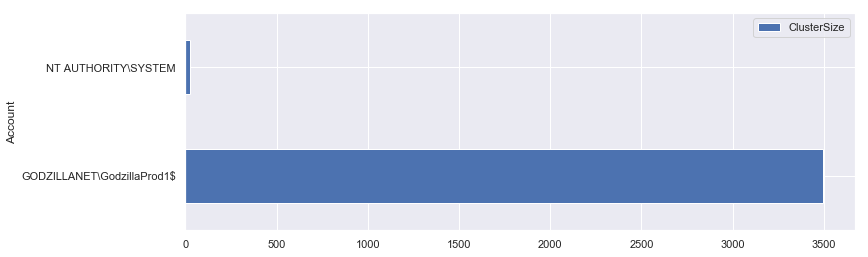

In [40]:

from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score

host_logons = qry.list_host_logons(provs=[logon_query_times], **params_dict)

%matplotlib inline

if host_logons is not None and not host_logons.empty:
    logon_features = host_logons.copy()
    logon_features['AccountNum'] = host_logons.apply(lambda x: _string_score(x.Account), axis=1)
    logon_features['LogonIdNum'] = host_logons.apply(lambda x: _string_score(x.TargetLogonId), axis=1)
    logon_features['LogonHour'] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

    # you might need to play around with the max_cluster_distance parameter.
    # decreasing this gives more clusters.
    (clus_logons, _, _) = dbcluster_events(data=logon_features, time_column='TimeGenerated',
                                           cluster_columns=['AccountNum',
                                                            'LogonType'],
                                           max_cluster_distance=0.0001)
    display(Markdown(f'Number of input events: {len(host_logons)}'))
    display(Markdown(f'Number of clustered events: {len(clus_logons)}'))
    display(Markdown('### Distinct host logon patterns'))
    clus_logons.sort_values('TimeGenerated')
    nbdisp.display_logon_data(clus_logons)
    
    display(Markdown('### Logon timeline.'))
    tooltip_cols = ['TargetUserName', 'TargetDomainName', 'SubjectUserName', 
                    'SubjectDomainName', 'LogonType', 'IpAddress']
    nbdisp.display_timeline(data=host_logons.query('TargetLogonId != "0x3e7"'),
                            overlay_data=host_logons.query('TargetLogonId == "0x3e7"'),
                            title="Logons (blue=user, green=system)", 
                            source_columns=tooltip_cols, height=200)
    
    display(Markdown('### Counts of logon events by logon type.'))
    display(Markdown('Min counts for each logon type highlighted.'))
    logon_by_type = (host_logons[['Account', 'LogonType', 'EventID']]
                    .groupby(['Account','LogonType']).count().unstack()
                    .fillna(0)
                    .style
                    .background_gradient(cmap='viridis', low=.5, high=0)
                    .format("{0:0>3.0f}"))
    display(logon_by_type)
    key = 'logon type key = {}'.format('; '.join([f'{k}: {v}' for k,v in mas.nbdisplay._WIN_LOGON_TYPE_MAP.items()]))
    display(Markdown(key))
    
    display(Markdown('### Relative frequencies by account'))
    plt.rcParams['figure.figsize'] = (12, 4)
    clus_logons.plot.barh(x="Account", y="ClusterSize")
else:
    display(Markdown('No logon events found for host.'))

<a id='failed logons'></a>[Contents](#toc)
### Failed Logons

In [41]:
failedLogons = qry.list_host_logon_failures(provs=[query_times], **params_dict)
if failedLogons.shape[0] == 0:
    display(print('No logon failures recorded for this host between {security_alert.start} and {security_alert.start}'))

failedLogons

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:20.560,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx
1,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:23.070,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx
2,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:25.473,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx
3,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:27.980,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx
4,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:30.780,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx
5,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:33.460,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx
6,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:36.097,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx
7,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:38.753,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx
8,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:41.257,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx
9,802d39e1-9d70-404d-832c-2de5e2478eda,\OspAzureRDP,4625,2019-02-26 19:53:43.850,c2015ff2-349c-45a6-9aa5-952326684ac1,GodzillaProd1.Godzillanet.com,-,-,S-1-0-0,OspAzureRDP,,S-1-0-0,,NtLmSsp,3,NTLM,0xc000006d,-,rdpbruter-6ddcbbd8dd-mp2gx


<a id='examine_win_logon_sess'></a>[Contents](#toc)
## Examine a Logon Session

### Select a Logon ID To Examine

In [42]:
import re
dist_logons = clus_logons.sort_values('TimeGenerated')[['TargetUserName', 'TimeGenerated', 
                                                        'LastEventTime', 'LogonType', 
                                                        'ClusterSize']]
items = dist_logons.apply(lambda x: (f'{x.TargetUserName}:    '
                                     f'(logontype={x.LogonType})   '
                                     f'timerange={x.TimeGenerated} - {x.LastEventTime}    '
                                     f'count={x.ClusterSize}'),
                          axis=1).values.tolist()

def get_selected_logon_cluster(selected_item):
    acct_match = re.search(r'(?P<acct>[^:]+):\s+\(logontype=(?P<l_type>[^)]+)', selected_item)
    if acct_match:
        acct = acct_match['acct']
        l_type = int(acct_match['l_type'])
        return host_logons.query('TargetUserName == @acct and LogonType == @l_type')

logon_list_regex = r'''
(?P<acct>[^:]+):\s+
\(logontype=(?P<logon_type>[^)]+)\)\s+
\(timestamp=(?P<time>[^)]+)\)\s+
logonid=(?P<logonid>[0-9a-fx)]+)
'''

def get_selected_logon(selected_item):
    acct_match = re.search(logon_list_regex, selected_item, re.VERBOSE)
    if acct_match:
        acct = acct_match['acct']
        logon_type = int(acct_match['logon_type'])
        time_stamp = pd.to_datetime(acct_match['time'])
        logon_id = acct_match['logonid']
        return host_logons.query('TargetUserName == @acct and LogonType == @logon_type'
                                 ' and TargetLogonId == @logon_id')
    
logon_wgt = mas.SelectString(description='Select logon cluster to examine', 
                             item_list=items, height='200px', width='100%', auto_display=True)

Select(description='Select logon cluster to examine', layout=Layout(height='200px', width='100%'), options=('S…

In [43]:
# Calculate time range based on the logons from previous section
selected_logon_cluster = get_selected_logon_cluster(logon_wgt.value)

if len(selected_logon_cluster) > 20:
    display(Markdown('<h3><p style="color:red">Warning: the selected '
                     'cluster has a high number of logons.</p></h1><br>'
                     'Processes for these logons may be very slow '
                     'to retrieve and result in high memory usage.<br>'
                     'You may wish to narrow the time range and sample'
                     'the data before running the query for the full range.'))
    
logon_time = selected_logon_cluster['TimeGenerated'].min()
last_logon_time = selected_logon_cluster['TimeGenerated'].max()
time_diff = int((last_logon_time - logon_time).total_seconds() / (60 * 60) + 2)

# set the origin time to the time of our alert
proc_query_times = mas.QueryTime(units='hours', origin_time=logon_time,
                           before=1, after=time_diff, max_before=60, max_after=120)
proc_query_times.display()

<h3><p style="color:red">Warning: the selected cluster has a high number of logons.</p></h1><br>Processes for these logons may be very slow to retrieve and result in high memory usage.<br>You may wish to narrow the time range and samplethe data before running the query for the full range.

HTML(value='<h4>Set query time boundaries</h4>')

In [44]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features
print('Getting process events...', end='')
processes_on_host = qry.list_processes(provs=[proc_query_times], **params_dict)
print('done')
print('Clustering...', end='')
feature_procs = add_process_features(input_frame=processes_on_host,
                                     path_separator=params_dict['path_separator'])

feature_procs['accountNum'] = feature_procs.apply(lambda x: _string_score(x.Account), axis=1)
# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs,
                                                    cluster_columns=['commandlineTokensFull', 
                                                                     'pathScore',
                                                                     'accountNum',
                                                                     'isSystemSession'],
                                                    max_cluster_distance=0.0001)
print('done')
print('Number of input events:', len(feature_procs))
print('Number of clustered events:', len(clus_events))

def view_logon_sess(x=''):
    global selected_logon
    selected_logon = get_selected_logon(x)
    logonId = selected_logon['TargetLogonId'].iloc[0]
    sess_procs = (processes_on_host.query('TargetLogonId == @logonId | SubjectLogonId == @logonId')
                                          [['NewProcessName', 'CommandLine', 'TargetLogonId']]
                  .drop_duplicates())
    display(sess_procs)

selected_logon_cluster = get_selected_logon_cluster(logon_wgt.value)
    
selected_tgt_logon = selected_logon_cluster['TargetUserName'].iat[0]
system_logon = selected_tgt_logon.lower() == 'system' or selected_tgt_logon.endswith('$')

if system_logon:
    
    display(Markdown('<h3><p style="color:red">Warning: the selected '
                     'account name appears to be a system account.</p></h1><br>'
                     '<i>It is difficult to accurately associate processes '
                     'with the specific logon sessions.<br>'
                     'Showing clustered events for entire time selection.'))
    display(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                    'NewProcessName', 'CommandLine', 
                                    'ClusterSize', 'commandlineTokensFull',
                                    'pathScore', 'isSystemSession']])

# Display a pick list for logon instances
items = (selected_logon_cluster
         .sort_values('TimeGenerated')
         .apply(lambda x: (f'{x.TargetUserName}:    '
                           f'(logontype={x.LogonType})   '
                           f'(timestamp={x.TimeGenerated})    '
                           f'logonid={x.TargetLogonId}'),
                axis=1).values.tolist())
sess_w = widgets.Select(options=items, description='Select logon instance to examine', **WIDGET_DEFAULTS)

widgets.interactive(view_logon_sess, x=sess_w)

Getting process events...done
Clustering...done
Number of input events: 3780
Number of clustered events: 44


<h3><p style="color:red">Warning: the selected account name appears to be a system account.</p></h1><br><i>It is difficult to accurately associate processes with the specific logon sessions.<br>Showing clustered events for entire time selection.

,TimeGenerated,LastEventTime,NewProcessName,CommandLine,ClusterSize,commandlineTokensFull,pathScore,isSystemSession
3095,2019-02-26 01:00:01.640,2019-02-26 04:02:39.213,C:\Windows\System32\taskhostex.exe,taskhostex.exe,2.0,2,3364,True
3357,2019-02-26 04:02:39.260,2019-02-26 04:02:44.320,C:\Windows\System32\aitagent.exe,C:\Windows\system32\aitagent.EXE /increment,1.0,7,3107,True
3359,2019-02-26 04:02:39.277,2019-02-26 04:02:44.320,C:\Windows\System32\rundll32.exe,"C:\Windows\system32\rundll32.exe C:\Windows\system32\invagent.dll,RunUpdate",1.0,12,3020,True
3358,2019-02-26 04:02:39.277,2019-02-26 04:02:44.320,C:\Windows\System32\taskhost.exe,taskhost.exe /RuntimeWide,1.0,3,3143,True
3361,2019-02-26 04:02:39.293,2019-02-26 04:02:44.320,C:\Windows\System32\wermgr.exe,C:\Windows\system32\wermgr.exe -queuereporting,1.0,7,2922,True
3360,2019-02-26 04:02:39.293,2019-02-26 04:02:44.320,C:\Windows\System32\rundll32.exe,"C:\Windows\system32\rundll32.exe Windows.Storage.ApplicationData.dll,CleanupTemporaryState",1.0,10,3020,True
3362,2019-02-26 04:02:39.310,2019-02-26 04:02:44.320,C:\Windows\System32\sc.exe,C:\Windows\system32\sc.exe start w32time task_started,1.0,8,2476,True
3365,2019-02-26 04:02:39.323,2019-02-26 04:02:44.320,C:\Windows\System32\WerFault.exe,"""C:\Windows\system32\WerFault.exe"" -k -lcq",1.0,11,3072,True
3364,2019-02-26 04:02:39.323,2019-02-26 04:02:44.320,C:\Windows\System32\svchost.exe,C:\Windows\System32\svchost.exe -k WerSvcGroup,1.0,8,3040,True
3367,2019-02-26 04:02:39.387,2019-02-26 04:02:44.320,C:\Windows\Microsoft.NET\Framework64\v4.0.30319\ngentask.exe,"""C:\Windows\Microsoft.NET\Framework64\v4.0.30319\NGenTask.exe"" /RuntimeWide /StopEvent:812",1.0,17,5400,True


interactive(children=(Select(description='Select logon instance to examine', layout=Layout(width='95%'), optio…

<a id='cmdlineiocs'></a>[Contents](#toc)
# Check for IOCs in Commandline for current session
This section looks for Indicators of Compromise (IoC) within the data sets passed to it.

The first section looks at the commandlines for the processes in the selected session. It also looks for base64 encoded strings within the data - this is a common way of hiding attacker intent. It attempts to decode any strings that look like base64. Additionally, if the base64 decode operation returns any items that look like a base64 encoded string or file, a gzipped binary sequence, a zipped or tar archive, it will attempt to extract the contents before searching for potentially interesting IoC observables within the decoded data.

In [45]:
if not system_logon:
    logonId = selected_logon['TargetLogonId'].iloc[0]
    sess_procs = (processes_on_host.query('TargetLogonId == @logonId | SubjectLogonId == @logonId'))
else:
    sess_procs = clus_events
    
ioc_extractor = sectools.IoCExtract()
os_family = host_entity.OSType if host_entity.OSType else 'Windows'

ioc_df = ioc_extractor.extract(data=sess_procs, 
                               columns=['CommandLine'],
                               os_family=os_family,
                               ioc_types=['ipv4', 'ipv6', 'dns', 'url',
                                          'md5_hash', 'sha1_hash', 'sha256_hash'])
if len(ioc_df):
    display(Markdown("### IoC patterns found in process set."))
    display(ioc_df)
else:
    display(Markdown("### No IoC patterns found in process tree."))

### IoC patterns found in process set.

,IoCType,Observable,SourceIndex
0,dns,Microsoft.Windows.Server.10.0.Discovery.Probe.vbs,1066
1,dns,GodzillaProd1.Godzillanet.com,1066
2,dns,Windows.Storage.ApplicationData.dll,3360
3,ipv4,168.63.129.16,782


### If any Base64 encoded strings, decode and search for IoCs in the results.
For simple strings the Base64 decoded output is straightforward. However for nested encodings this can get a little complex and difficult to represent in a tabular format.

**Columns**
 - reference - The index of the row item in dotted notation in depth.seq pairs (e.g. 1.2.2.3 would be the 3 item at depth 3 that is a child of the 2nd item found at depth 1). This may not always be an accurate notation - it is mainly use to allow you to associate an individual row with the reference value contained in the full_decoded_string column of the topmost item).
 - original_string - the original string before decoding.
 - file_name - filename, if any (only if this is an item in zip or tar file).
 - file_type - a guess at the file type (this is currently elementary and only includes a few file types).
 - input_bytes - the decoded bytes as a Python bytes string.
 - decoded_string - the decoded string if it can be decoded as a UTF-8 or UTF-16 string. Note: binary sequences may often successfully decode as UTF-16 strings but, in these cases, the decodings are meaningless.
 - encoding_type - encoding type (UTF-8 or UTF-16) if a decoding was possible, otherwise 'binary'.
 - file_hashes - collection of file hashes for any decoded item.
 - md5 - md5 hash as a separate column.
 - sha1 - sha1 hash as a separate column.
 - sha256 - sha256 hash as a separate column.
 - printable_bytes - printable version of input_bytes as a string of \xNN values
 - src_index - the index of the row in the input dataframe from which the data came.
 - full_decoded_string - the full decoded string with any decoded replacements. This is only really useful for top-level items, since nested items will only show the 'full' string representing the child fragment.

In [46]:
dec_df = sectools.b64.unpack_items(data=sess_procs, column='CommandLine')
if len(dec_df) > 0:
    display(HTML("<h3>Decoded base 64 command lines</h3>"))
    display(HTML("Decoded values and hashes of decoded values shown below."))
    display(HTML('Warning - some binary patterns may be decodable as unicode strings. '
                 'In these cases you should ignore the "decoded_string" column '
                 'and treat the encoded item as a binary - using the "printable_bytes" '
                 'column or treat the decoded_string as a binary (bytes) value.'))
    
    display(dec_df[['full_decoded_string', 'decoded_string', 'original_string', 'printable_bytes', 'file_hashes']])

    ioc_dec_df = ioc_extractor.extract(data=dec_df, columns=['full_decoded_string'])
    if len(ioc_dec_df):
        display(HTML("<h3>IoC patterns found in events with base64 decoded data</h3>"))
        display(ioc_dec_df)
        ioc_df = ioc_df.append(ioc_dec_df ,ignore_index=True)
else:
    print("No base64 encodings found.")

No base64 encodings found.


<a id='virustotallookup'></a>[Contents](#toc)
## Virus Total Lookup
This section uses the popular Virus Total service to check any recovered IoCs against VTs database.

To use this you need an API key from virus total, which you can obtain here: https://www.virustotal.com/.

Note that VT throttles requests for free API keys to 4/minute. If you are unable to process the entire data set, try splitting it and submitting smaller chunks.

**Things to note:**
- Virus Total lookups include file hashes, domains, IP addresses and URLs.
- The returned data is slightly different depending on the input type
- The VTLookup class tries to screen input data to prevent pointless lookups. E.g.:
  - Only public IP Addresses will be submitted (no loopback, private address space, etc.)
  - URLs with only local (unqualified) host parts will not be submitted.
  - Domain names that are unqualified will not be submitted.
  - Hash-like strings (e.g 'AAAAAAAAAAAAAAAAAA') that do not appear to have enough entropy to be a hash will not be submitted.

**Output Columns**
 - Observable - The IoC observable submitted
 - IoCType - the IoC type
 - Status - the status of the submission request
 - ResponseCode - the VT response code
 - RawResponse - the entire raw json response
 - Resource - VT Resource
 - SourceIndex - The index of the Observable in the source DataFrame. You can use this to rejoin to your original data.
 - VerboseMsg - VT Verbose Message
 - ScanId - VT Scan ID if any
 - Permalink - VT Permanent URL describing the resource
 - Positives - If this is not zero, it indicates the number of malicious reports that VT holds for this observable.
 - MD5 - The MD5 hash, if any
 - SHA1 - The MD5 hash, if any
 - SHA256 - The MD5 hash, if any
 - ResolvedDomains - In the case of IP Addresses, this contains a list of all domains that resolve to this IP address
 - ResolvedIPs - In the case Domains, this contains a list of all IP addresses resolved from the domain.
 - DetectedUrls - Any malicious URLs associated with the observable.

In [47]:
vt_key = mas.GetEnvironmentKey(env_var='VT_API_KEY',
                           help_str='To obtain an API key sign up here https://www.virustotal.com/',
                           prompt='Virus Total API key:')
vt_key.display()

In [48]:
if vt_key.value and ioc_df is not None and not ioc_df.empty:
    vt_lookup = sectools.VTLookup(vt_key.value, verbosity=2)

    print(f'{len(ioc_df)} items in input frame')
    supported_counts = {}
    for ioc_type in vt_lookup.supported_ioc_types:
        supported_counts[ioc_type] = len(ioc_df[ioc_df['IoCType'] == ioc_type])
    print('Items in each category to be submitted to VirusTotal')
    print('(Note: items have pre-filtering to remove obvious erroneous '
          'data and false positives, such as private IPaddresses)')
    print(supported_counts)
    print('-' * 80)
    vt_results = vt_lookup.lookup_iocs(data=ioc_df, type_col='IoCType', src_col='Observable')
    display(vt_results)

4 items in input frame
Items in each category to be submitted to VirusTotal
(Note: items have pre-filtering to remove obvious erroneous data and false positives, such as private IPaddresses)
{'ipv4': 1, 'dns': 3, 'url': 0, 'md5_hash': 0, 'sha1_hash': 0, 'sh256_hash': 0}
--------------------------------------------------------------------------------
Submitting observables: "168.63.129.16", type "ipv4" to VT. (Source index 782)
Submitting observables: "Microsoft.Windows.Server.10.0.Discovery.Probe.vbs", type "dns" to VT. (Source index 1066)
Submitting observables: "GodzillaProd1.Godzillanet.com", type "dns" to VT. (Source index 1066)
Submitting observables: "Windows.Storage.ApplicationData.dll", type "dns" to VT. (Source index 3360)
Submission complete. 4 responses from 4 input rows


,Observable,IoCType,Status,ResponseCode,RawResponse,Resource,SourceIndex,VerboseMsg,Resource,ScanId,Permalink,Positives,MD5,SHA1,SHA256,ResolvedDomains,ResolvedIPs,DetectedUrls
0,168.63.129.16,ipv4,Success,1,"{""undetected_referrer_samples"": [{""positives"": 0, ""total"": 57, ""sha256"": ""6067ca6d8b265ef1521302...",NaN,782,IP address in dataset,NaN,NaN,NaN,0,NaN,NaN,NaN,"cgmapparel.com, mail.vedamic.ga, modern-deployment.com, oasis-smartsim.com, righttrack.xyz",NaN,
1,Microsoft.Windows.Server.10.0.Discovery.Probe.vbs,dns,Success,0,"{""response_code"": 0, ""verbose_msg"": ""Domain not found""}",NaN,1066,Domain not found,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GodzillaProd1.Godzillanet.com,dns,Success,0,"{""response_code"": 0, ""verbose_msg"": ""Domain not found""}",NaN,1066,Domain not found,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Windows.Storage.ApplicationData.dll,dns,Success,0,"{""response_code"": 0, ""verbose_msg"": ""Domain not found""}",NaN,3360,Domain not found,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='comms_to_other_hosts'></a>[Contents](#toc)
# Network Check Communications with Other Hosts

In [49]:
# Azure Network Analytics Base Query

    
az_net_analytics_query =r'''
AzureNetworkAnalytics_CL 
| where SubType_s == 'FlowLog'
| where FlowStartTime_t >= datetime({start})
| where FlowEndTime_t <= datetime({end})
| project TenantId, TimeGenerated, 
    FlowStartTime = FlowStartTime_t, 
    FlowEndTime = FlowEndTime_t, 
    FlowIntervalEndTime = FlowIntervalEndTime_t, 
    FlowType = FlowType_s,
    ResourceGroup = split(VM_s, '/')[0],
    VMName = split(VM_s, '/')[1],
    VMIPAddress = VMIP_s, 
    PublicIPs = extractall(@"([\d\.]+)[|\d]+", dynamic([1]), PublicIPs_s),
    SrcIP = SrcIP_s,
    DestIP = DestIP_s,
    ExtIP = iif(FlowDirection_s == 'I', SrcIP_s, DestIP_s),
    L4Protocol = L4Protocol_s, 
    L7Protocol = L7Protocol_s, 
    DestPort = DestPort_d, 
    FlowDirection = FlowDirection_s,
    AllowedOutFlows = AllowedOutFlows_d, 
    AllowedInFlows = AllowedInFlows_d,
    DeniedInFlows = DeniedInFlows_d, 
    DeniedOutFlows = DeniedOutFlows_d,
    RemoteRegion = AzureRegion_s,
    VMRegion = Region_s
| extend AllExtIPs = iif(isempty(PublicIPs), pack_array(ExtIP), 
                         iif(isempty(ExtIP), PublicIPs, array_concat(PublicIPs, pack_array(ExtIP)))
                         )
| project-away ExtIP
| mvexpand AllExtIPs
{where_clause}
'''

ip_q_times = mas.QueryTime(label='Set time bounds for network queries',
                           units='hour', max_before=48, before=10, after=5, 
                           max_after=24)
ip_q_times.display()

HTML(value='<h4>Set time bounds for network queries</h4>')

### Query Flows by Host IP Addresses

In [50]:
if 'AzureNetworkAnalytics_CL' not in table_index:
    print('No network flow data available.')
    az_net_comms_df = None
else:
    all_host_ips = host_entity.private_ips + host_entity.public_ips + [host_entity.IPAddress]
    host_ips = {'\'{}\''.format(i.Address) for i in all_host_ips}
    host_ip_list = ','.join(host_ips)

    if not host_ip_list:
        raise ValueError('No IP Addresses for host. Cannot lookup network data')

    az_ip_where = f'''
    | where (VMIPAddress in ({host_ip_list}) 
            or SrcIP in ({host_ip_list}) 
            or DestIP in ({host_ip_list}) 
            ) and 
        (AllowedOutFlows > 0 or AllowedInFlows > 0)'''
    print('getting data...')
    az_net_query_byip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                      start = ip_q_times.start,
                                                      end = ip_q_times.end)

    net_default_cols = ['FlowStartTime', 'FlowEndTime', 'VMName', 'VMIPAddress', 
                    'PublicIPs', 'SrcIP', 'DestIP', 'L4Protocol', 'L7Protocol',
                    'DestPort', 'FlowDirection', 'AllowedOutFlows', 
                    'AllowedInFlows']

    %kql -query az_net_query_byip
    az_net_comms_df = _kql_raw_result_.to_dataframe()
    az_net_comms_df[net_default_cols]

    if len(az_net_comms_df) > 0:
        import warnings

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            az_net_comms_df['TotalAllowedFlows'] = az_net_comms_df['AllowedOutFlows'] + az_net_comms_df['AllowedInFlows']
            sns.catplot(x="L7Protocol", y="TotalAllowedFlows", col="FlowDirection", data=az_net_comms_df)
            sns.relplot(x="FlowStartTime", y="TotalAllowedFlows", 
                        col="FlowDirection", kind="line", 
                        hue="L7Protocol", data=az_net_comms_df).set_xticklabels(rotation=50)

        nbdisp.display_timeline(data=az_net_comms_df.query('AllowedOutFlows > 0'),
                                 overlay_data=az_net_comms_df.query('AllowedInFlows > 0'),
                                 title='Network Flows (out=blue, in=green)',
                                 time_column='FlowStartTime',
                                 source_columns=['FlowType', 'AllExtIPs', 'L7Protocol', 'FlowDirection'],
                                 height=300)
    else:
        print('No network data for specified time range.')

getting data...
No network data for specified time range.


### Flow Summary

In [51]:
if az_net_comms_df is not None and not az_net_comms_df.empty:
    cm = sns.light_palette("green", as_cmap=True)

    cols = ['VMName', 'VMIPAddress', 'PublicIPs', 'SrcIP', 'DestIP', 'L4Protocol',
            'L7Protocol', 'DestPort', 'FlowDirection', 'AllExtIPs', 'TotalAllowedFlows']
    flow_index = az_net_comms_df[cols].copy()
    def get_source_ip(row):
        if row.FlowDirection == 'O':
            return row.VMIPAddress if row.VMIPAddress else row.SrcIP
        else:
            return row.AllExtIPs if row.AllExtIPs else row.DestIP

    def get_dest_ip(row):
        if row.FlowDirection == 'O':
            return row.AllExtIPs if row.AllExtIPs else row.DestIP
        else:
            return row.VMIPAddress if row.VMIPAddress else row.SrcIP

    flow_index['source'] = flow_index.apply(get_source_ip, axis=1)
    flow_index['target'] = flow_index.apply(get_dest_ip, axis=1)
    flow_index['value'] = flow_index['L7Protocol']

    (flow_index[['source', 'target', 'value', 'L7Protocol', 'FlowDirection', 'TotalAllowedFlows']]
     .groupby(['source', 'target', 'value', 'L7Protocol', 'FlowDirection'])
     .sum().unstack().style.background_gradient(cmap=cm))

## GeoIP Map of External IPs

In [53]:
from msticpy.nbtools.foliummap import FoliumMap
folium_map = FoliumMap()

if az_net_comms_df is None or az_net_comms_df.empty:
    print('No network flow data available.')
else:    
    ip_locs_in = set()
    ip_locs_out = set()
    for _, row in az_net_comms_df.iterrows():
        ip = row.AllExtIPs

        if ip in ip_locs_in or ip in ip_locs_out or not ip:
            continue
        ip_entity = mas.IpAddress(Address=ip)
        iplocation.lookup_ip(ip_entity=ip_entity)
        if not ip_entity.Location:
            continue
        ip_entity.AdditionalData['protocol'] = row.L7Protocol
        if row.FlowDirection == 'I':
            ip_locs_in.add(ip_entity)
        else:
            ip_locs_out.add(ip_entity)

    display(HTML('<h3>External IP Addresses communicating with host</h3>'))
    display(HTML('Numbered circles indicate multiple items - click to expand'))
    display(HTML('Location markers: Blue = outbound, Purple = inbound, Green = Host'))

    icon_props = {'color': 'green'}
    folium_map.add_ip_cluster(ip_entities=host_entity.public_ips,
                                **icon_props)
    icon_props = {'color': 'blue'}
    folium_map.add_ip_cluster(ip_entities=ip_locs_out,
                                **icon_props)
    icon_props = {'color': 'purple'}
    folium_map.add_ip_cluster(ip_entities=ip_locs_in,
                                **icon_props)

    display(folium_map.folium_map)
    display(Markdown('<p style="color:red">Warning: the folium mapping library '
                     'does not display correctly in some browsers.</p><br>'
                     'If you see a blank image please retry with a different browser.'))

No network flow data available.


<a id='appendices'></a>[Contents](#toc)
# Appendices

## Available DataFrames

In [ ]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

## Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```